In [32]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils 
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

In [34]:
PROPHET_PATH = '../data/prophet/'

In [35]:
glob.glob(PROPHET_PATH+'*')

['../data/prophet/ds.f',
 '../data/prophet/page_index.f',
 '../data/prophet/pagedf.f',
 '../data/prophet/v0',
 '../data/prophet/v0.1']

In [36]:
pagedf = pd.read_feather(PROPHET_PATH+'pagedf.f')
ds = pd.read_feather(PROPHET_PATH+'ds.f')

## Version 0.1
Should set version directory name in next cell. Should describe version specifics (outliers, holidays, validation period). How will the validation period be communcated to the SMAPE scoring stuff?

* Val indexing on -60
* No outlier fixing
* Linear growth

### Remarks
* Gives negative predictions (due to linear negative growth) which can give negative sMAPE
* It's including all the leading NaN's in training the model? Should slice that off before making model I think?
    * -> Doesn't seem to affect it - Prophet just deals with it
    * -> The sMAPE functions we are using seems to deal with them fine too? Should really check this.

In [37]:
# should break if the dir already exists - avoids accidental overwriting
VERSION = 'v0.1/'
val_lims = (0,-60)
os.makedirs(PROPHET_PATH+VERSION)

FileExistsError: [Errno 17] File exists: '../data/prophet/v0.1/'

In [49]:
pagedf = pagedf.loc[:,:'10']

# WARNING:
Turned off the chained assignment warning - when slicing dfs they can return copies sometimes instead,
which will mean your assignment wont be done on the actual base df.
Not sure why it's still compaining at me when I'm using loc everywhere... Maybe something 

In [50]:
pd.options.mode.chained_assignment = None

In [172]:
def process_page(page):
    print(page)
    df = ds.join(pagedf[page])
    df.columns = ['ds','y']
    # note this is doing validation on last 60 days
    # should also consider doing validation on the time period we are forcasting
    traindf = df.iloc[val_lims[0]:val_lims[1]]
    traindf['train'] = 1 # feather won't serialize bool so 1s and 0s...
    # do outlier removal here
    #traindf.loc[traindf.y > traindf.y.quantile(.95), ['y']] = None
    m = Prophet(yearly_seasonality=True)
    m.fit(traindf)
    forecast = m.predict(ds)
    forecast = forecast.join(df.y)
    forecast = forecast.join(traindf.loc[:,['train']]).fillna({'train':0}) # 0 bools
    #forecast.loc[forecast['train'] != 1,['train']] = 0 # 0 bools
    forecast.to_feather(PROPHET_PATH+VERSION+page+'df.f')
    with open(PROPHET_PATH+VERSION+page+'m.pk', 'wb') as file:
        pk.dump(m,file)
    full_smape = wiki.val.smape_df(forecast,'y','yhat')
    val_smape = wiki.val.smape_df(forecast[forecast['train'] == 0],'y','yhat')
    return (page, full_smape, val_smape)

In [173]:
def wrapper(pages):
    val_results = []
    for page in tqdm(pages):
        val_results.append(process_page(page))
    return val_results

In [174]:
total_proc = mp.cpu_count()

In [92]:
col_split = np.array_split(pagedf.columns, total_proc)
mp_pool = mp.Pool(total_proc)

  0%|          | 0/3 [00:00<?, ?it/s]

3
6
9
0
0    0.204073
1    0.155718
2    0.112622
3    0.170950
4    0.166262
dtype: float64
0     23.592447
1     58.718862
2    111.207290
3     47.908395
4     31.591336
dtype: float64
490    0.201023
491    0.231926
492    0.173565
493    0.231874
494    0.172190
dtype: float64
490     20.915665
491     15.585800
492     38.677169
493     27.492608
494    107.079367
dtype: float64


 33%|███▎      | 1/3 [00:02<00:05,  2.55s/it]

1
0    0.095534
1    0.075975
2    0.083763
3    0.103700
4    0.073511
dtype: float64
365    0.423086
366    0.117065
367    0.284702
368    0.306626
369    0.149421
dtype: float640     74.390481
1    121.026640
2     80.616239
3     31.436901
4     36.759027
dtype: float64

0    0.327676
1    0.192835
2    0.187224
3    0.603852
4    0.138904
dtype: float64365     88.357577
366    114.577295
367     73.552154
368     30.412542
369    159.844876
dtype: float64

490    0.303348
491    0.245188
492    0.249230
493    0.235247
494    0.295948
dtype: float64
0     13.625601
1     65.169882
2     93.176361
3    111.334348
4    142.406426
dtype: float64
490    0.213884
491    0.142323
492    0.115241
493    0.199752
494    0.596372
dtype: float64490     4.385731
491    36.860158
492    31.480769
493    21.464409
494    23.011814
dtype: float64



 50%|█████     | 1/2 [00:02<00:02,  2.64s/it]

10
490     12.982784
491     31.369543
492     26.450388
493    149.938046
494     91.764296
dtype: float64490    0.166297
491    0.144706
492    0.181460
493    0.144471
494    0.159862
dtype: float64


 33%|███▎      | 1/3 [00:02<00:05,  2.66s/it]


490     55.679715
491     47.967739
492     34.673916
493    103.095044
494     49.870669
dtype: float64
7


 33%|███▎      | 1/3 [00:02<00:05,  2.68s/it]

4
291    0.362660
292    0.977404
293    0.195479
294    0.216208
295    0.151975
dtype: float640    0.136487
1    0.161755
2    0.179021
3    0.244326
4    0.181861
dtype: float64

291      9.562518
292    125.351680
293    107.918646
294    162.998530
295    186.839929
dtype: float645     0.122298
6     0.121017
13    0.049979
16    0.044633
17    0.049607
dtype: float64

5     183.646569
6     183.473392
13    159.983340
16    155.190248
17    200.000000
dtype: float64
0    38.812550
1    26.899161
2    32.421559
3    52.655866
4    79.028406
dtype: float64490    0.153693
491    0.106438
492    0.249562
493    0.179876
494    0.123625
dtype: float64490    0.553757
491    0.596886
492    0.165195
493    0.156398
494    0.321878
dtype: float64


490    134.935423
491     87.257970
492     64.463739
493     55.455793
494     38.220567
dtype: float64
490    128.664270
491    114.967759
492    103.144595
493    148.848606
494     79.609380
dtype: float64
490    0.175193
491    0.187909
4

 67%|██████▋   | 2/3 [00:05<00:02,  2.85s/it]


490    74.424175
491    50.991727
492     9.731674
493    95.986089
494    11.669188
dtype: float645



 67%|██████▋   | 2/3 [00:05<00:02,  2.80s/it]


2
0    0.577358
1    0.162686
2    0.240136
3    0.244162
4    0.243121
dtype: float64
0    208.758570
1    119.634381
2     49.858382
3      3.409334
4     38.564735
dtype: float64
490    0.591527
491    0.362803
492    0.685604
493    0.854811
494    1.204228
dtype: float64
490     46.819034
491     84.234756
492     24.619622
493     50.347597
494    107.250858
dtype: float64


 67%|██████▋   | 2/3 [00:06<00:02,  2.89s/it]

8
0    0.102658
1    0.077423
2    0.055876
3    0.063338
4    0.162204
dtype: float64
0    33.786140
1    19.175991
2    56.825894
3    42.118130
4    46.602382
dtype: float64
490    0.228325
491    0.249015
492    0.383580
493    0.187290
494    0.257485
dtype: float64
490    16.051619
491     0.791240
492    76.344206
493    61.177757
494    29.116377
dtype: float64


100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


0    0.016748
1    0.008974
2    0.010946
3    0.020496
4    0.014010
dtype: float64
0     80.585590
1    200.000000
2     17.286933
3    102.420715
4    200.000000
dtype: float64
490    0.037861
491    0.036396
492    0.034452
493    0.039815
494    0.078840
dtype: float64
490    41.524306
491    35.146436
492    25.842655
493    99.536284
494    53.678905
dtype: float64


100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


0    0.157651
1    0.239598
2    0.178658
3    0.182377
4    0.156845
dtype: float64
0    136.568862
1      8.012114
2     43.275764
3     68.404813
4     85.236817
dtype: float64
490    0.348085
491    0.320154
492    0.548546
493    0.380779
494    0.332937
dtype: float64
490    33.374080
491    50.072178
492    62.512220
493    16.166542
494    37.807046
dtype: float64


100%|██████████| 3/3 [00:08<00:00,  2.72s/it]


In [93]:
with utils.clock():
    %time fin = mp_pool.map(wrapper, col_split)

CPU times: user 71.4 ms, sys: 54.5 ms, total: 126 ms
Wall time: 8.44 s
Elapsed time 8.448054075241089 seconds


In [94]:
fin2 = [item for sublist in fin for item in sublist]

In [95]:
fin2

[('0', 50.814985397928844, 63.631257611154631),
 ('1', 47.47865101487028, 51.293459271888665),
 ('2', 71.783733084812212, 59.916423429826509),
 ('3', 47.294630658769499, 44.912849581367347),
 ('4', 597.65035397521285, 2024.4394071896088),
 ('5', 41.312534789626149, 47.515460366720134),
 ('6', -159.13762772478, -612.87251618886876),
 ('7', 61.209395543154017, 68.60909386853335),
 ('8', 34.319141132261748, 41.220362491473452),
 ('9', 26.1060112287458, 29.197131049681982),
 ('10', 32.792798976135749, 65.561638792196149)]

In [96]:
pd.DataFrame(fin2, columns=['index',VERSION[:-1]+'_full',VERSION[:-1]+'_val'])

,index,v0.1_full,v0.1_val
0,0,50.814985,63.631258
1,1,47.478651,51.293459
2,2,71.783733,59.916423
3,3,47.294631,44.912850
4,4,597.650354,2024.439407
5,5,41.312535,47.515460
6,6,-159.137628,-612.872516
7,7,61.209396,68.609094
8,8,34.319141,41.220362
9,9,26.106011,29.197131


In [97]:
df5 = pd.read_feather(PROPHET_PATH+VERSION+'4df.f')
with open(PROPHET_PATH+VERSION+'4m.pk', 'rb') as file:
    m5 = pk.load(file)

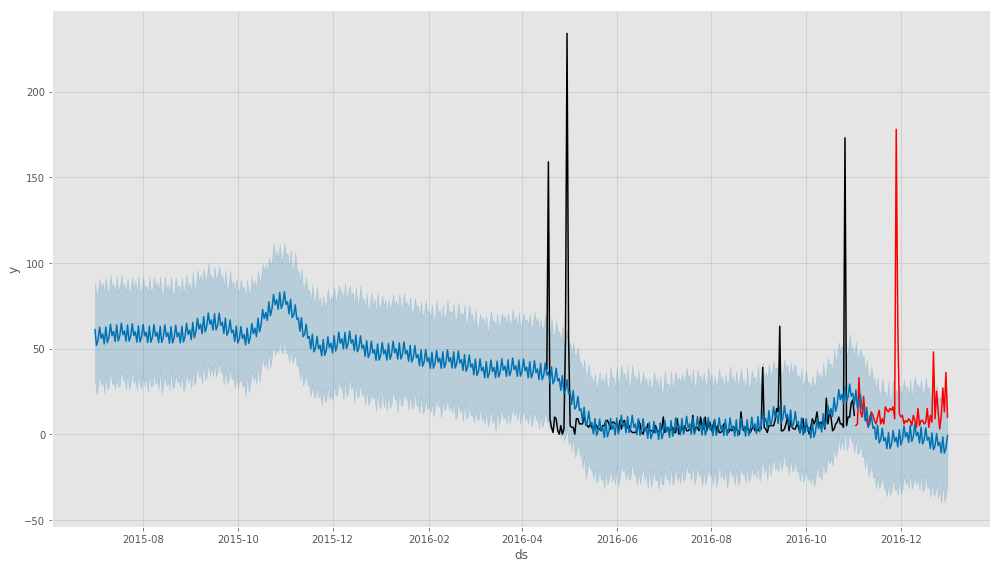

In [98]:
wiki.newphet.prophet_plot(df5)

In [107]:
wiki.val.smape(df5.y,df5.yhat)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
       ... 
520    11.0
521     6.0
522     8.0
523     7.0
524     9.0
525     8.0
526     5.0
527    11.0
528     8.0
529     4.0
530    15.0
531     5.0
532     8.0
533     8.0
534     6.0
535     7.0
536    15.0
537     4.0
538    11.0
539     7.0
540    48.0
541     9.0
542    25.0
543    13.0
544     3.0
545    11.0
546    27.0
547    13.0
548    36.0
549    10.0
Name: y, Length: 550, dtype: float64
0      61.067759
1      51.865663
2      54.921193
3      62.569826
4      56.031315
5      58.534267
6      52.757510
7      62.566222
8      53.438546
9      56.526307
10     64.166129
11     57.580086
12     60.000166
13     54.

597.65035397521274

In [116]:
df5.loc[526:547,['ds','yhat','y']]

,ds,yhat,y
526,2016-12-08,-4.308185,5.0
527,2016-12-09,-1.411128,11.0
528,2016-12-10,5.974697,8.0
529,2016-12-11,-0.923577,4.0
530,2016-12-12,1.132554,15.0
531,2016-12-13,-5.166069,5.0
532,2016-12-14,4.059433,8.0
533,2016-12-15,-5.697884,8.0
534,2016-12-16,-3.270556,6.0
535,2016-12-17,3.693922,7.0


In [111]:
(df5.y+df5.yhat).sum()/200

22.248696768161349

In [67]:
df6 = pd.read_feather(PROPHET_PATH+VERSION+'6df.f')
with open(PROPHET_PATH+VERSION+'6m.pk', 'rb') as file:
    m6 = pk.load(file)

In [68]:
df6.dropna(subset=['y'])

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,y,train
365,2016-06-30,0.000000,55.593724,-31.976561,-31.976561,55.593724,55.593724,-2.966008,47.744933,-7.509361,-7.509361,-7.509361,-24.467199,-24.467199,-24.467199,-31.976561,23.617163,61.0,1.0
366,2016-07-01,0.008065,55.165579,-36.752600,-36.752600,55.165579,55.165579,-6.500377,43.505861,-10.252587,-10.252587,-10.252587,-26.500014,-26.500014,-26.500014,-36.752600,18.412979,5.0,1.0
367,2016-07-02,0.016129,54.737435,-15.796963,-15.796963,54.737435,54.737435,14.619239,64.982417,12.541618,12.541618,12.541618,-28.338581,-28.338581,-28.338581,-15.796963,38.940472,18.0,1.0
368,2016-07-03,0.024194,54.309290,-18.984000,-18.984000,54.309290,54.309290,9.389892,61.479338,10.975845,10.975845,10.975845,-29.959845,-29.959845,-29.959845,-18.984000,35.325290,26.0,1.0
369,2016-07-04,0.032258,53.881145,-26.997039,-26.997039,53.881145,53.881145,2.585625,52.262531,4.348165,4.348165,4.348165,-31.345205,-31.345205,-31.345205,-26.997039,26.884106,3.0,1.0
370,2016-07-05,0.040323,53.453001,-40.928083,-40.928083,53.453001,53.453001,-15.259258,38.126947,-8.447262,-8.447262,-8.447262,-32.480821,-32.480821,-32.480821,-40.928083,12.524918,10.0,1.0
371,2016-07-06,0.048387,53.024856,-35.014219,-35.014219,53.024856,53.024856,-9.155755,43.651330,-1.656418,-1.656418,-1.656418,-33.357801,-33.357801,-33.357801,-35.014219,18.010637,5.0,1.0
372,2016-07-07,0.056452,52.596712,-41.481628,-41.481628,52.596712,52.596712,-14.353505,34.681083,-7.509361,-7.509361,-7.509361,-33.972267,-33.972267,-33.972267,-41.481628,11.115083,2.0,1.0
373,2016-07-08,0.064516,52.168567,-44.577882,-44.577882,52.168567,52.168567,-16.848095,32.707145,-10.252587,-10.252587,-10.252587,-34.325296,-34.325296,-34.325296,-44.577882,7.590685,16.0,1.0
374,2016-07-09,0.072581,51.740423,-21.881126,-21.881126,51.740423,51.740423,4.905726,53.691470,12.541618,12.541618,12.541618,-34.422744,-34.422744,-34.422744,-21.881126,29.859297,40.0,1.0


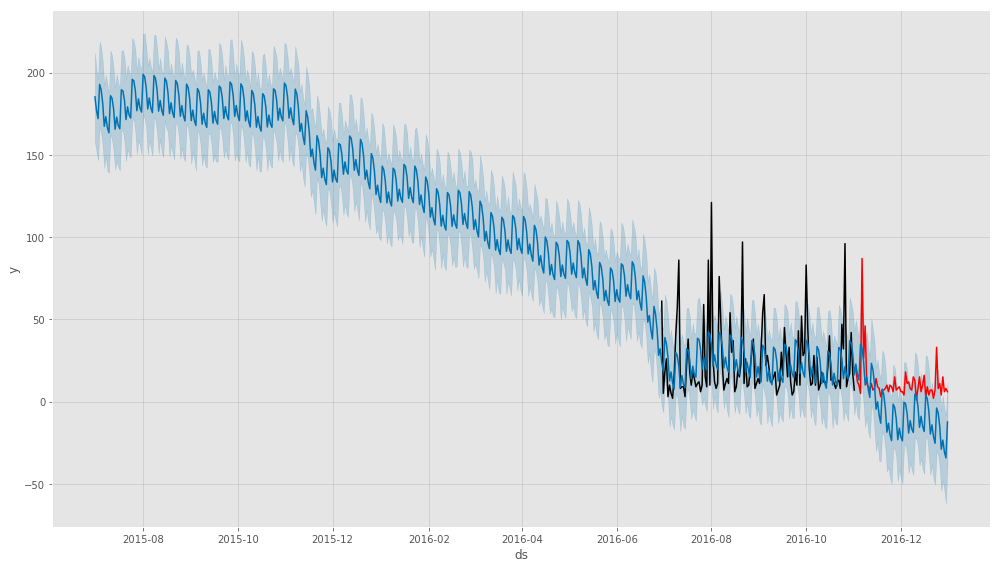

In [72]:
wiki.newphet.prophet_plot(df6)

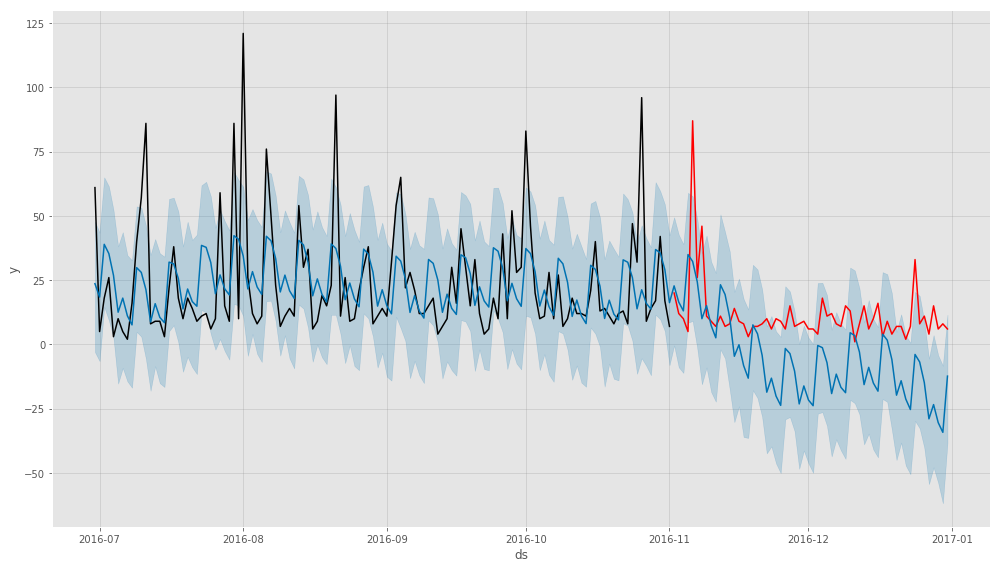

In [30]:
wiki.newphet.prophet_plot(df6.dropna(subset=['y']))

In [106]:
wiki.val.smape(df6.y,df6.yhat)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
       ... 
520     6.0
521     4.0
522    18.0
523    11.0
524    12.0
525     8.0
526     7.0
527    15.0
528    13.0
529     1.0
530     8.0
531    15.0
532     6.0
533    10.0
534    16.0
535     3.0
536     9.0
537     4.0
538     7.0
539     7.0
540     2.0
541     7.0
542    33.0
543     8.0
544    11.0
545     4.0
546    15.0
547     6.0
548     8.0
549     6.0
Name: y, Length: 550, dtype: float64
0      185.217872
1      176.950141
2      171.992536
3      192.794746
4      189.476798
5      181.349379
6      167.314287
7      173.128171
8      166.558680
9      163.352308
10     185.925345
11     184.364967
12     177.9503

-159.13762772478003

In [118]:
df6.y.dropna()

365    61.0
366     5.0
367    18.0
368    26.0
369     3.0
370    10.0
371     5.0
372     2.0
373    16.0
374    40.0
375    57.0
376    86.0
377     8.0
378     9.0
379     9.0
380     3.0
381    22.0
382    38.0
383    18.0
384    10.0
385    18.0
386    14.0
387     9.0
388    11.0
389    12.0
390     6.0
391    10.0
392    59.0
393    15.0
394     9.0
       ... 
520     6.0
521     4.0
522    18.0
523    11.0
524    12.0
525     8.0
526     7.0
527    15.0
528    13.0
529     1.0
530     8.0
531    15.0
532     6.0
533    10.0
534    16.0
535     3.0
536     9.0
537     4.0
538     7.0
539     7.0
540     2.0
541     7.0
542    33.0
543     8.0
544    11.0
545     4.0
546    15.0
547     6.0
548     8.0
549     6.0
Name: y, Length: 185, dtype: float64

In [171]:
(df6.y + df6.yhat).sort_values().iloc[:40]

548   -26.216370
545   -24.956431
547   -24.426251
540   -19.254804
541   -18.329949
520   -17.852790
519   -15.632113
517   -15.158846
513   -14.728320
538   -12.750877
506   -10.143956
512   -10.104073
526    -9.695058
510    -8.592281
546    -8.415253
518    -7.158301
511    -7.138254
539    -7.135310
524    -7.131294
549    -6.341875
533    -5.026239
544    -3.842281
527    -3.789709
525    -3.567684
516    -3.381339
532    -2.925760
534    -2.197246
537    -1.895225
531    -0.648605
505    -0.231610
543     1.148222
521     3.578389
509     3.750785
523     3.875917
529     4.399788
514     4.419240
530     5.041022
535     6.993186
504     8.872653
503     9.381435
dtype: float64

In [138]:
df6['cap'] = 50

In [147]:
df6.iloc[365:-60]

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,y,train,cap
365,2016-06-30,0.000000,55.593724,-31.976561,-31.976561,55.593724,55.593724,-2.966008,47.744933,-7.509361,-7.509361,-7.509361,-24.467199,-24.467199,-24.467199,-31.976561,23.617163,61.0,1.0,50
366,2016-07-01,0.008065,55.165579,-36.752600,-36.752600,55.165579,55.165579,-6.500377,43.505861,-10.252587,-10.252587,-10.252587,-26.500014,-26.500014,-26.500014,-36.752600,18.412979,5.0,1.0,50
367,2016-07-02,0.016129,54.737435,-15.796963,-15.796963,54.737435,54.737435,14.619239,64.982417,12.541618,12.541618,12.541618,-28.338581,-28.338581,-28.338581,-15.796963,38.940472,18.0,1.0,50
368,2016-07-03,0.024194,54.309290,-18.984000,-18.984000,54.309290,54.309290,9.389892,61.479338,10.975845,10.975845,10.975845,-29.959845,-29.959845,-29.959845,-18.984000,35.325290,26.0,1.0,50
369,2016-07-04,0.032258,53.881145,-26.997039,-26.997039,53.881145,53.881145,2.585625,52.262531,4.348165,4.348165,4.348165,-31.345205,-31.345205,-31.345205,-26.997039,26.884106,3.0,1.0,50
370,2016-07-05,0.040323,53.453001,-40.928083,-40.928083,53.453001,53.453001,-15.259258,38.126947,-8.447262,-8.447262,-8.447262,-32.480821,-32.480821,-32.480821,-40.928083,12.524918,10.0,1.0,50
371,2016-07-06,0.048387,53.024856,-35.014219,-35.014219,53.024856,53.024856,-9.155755,43.651330,-1.656418,-1.656418,-1.656418,-33.357801,-33.357801,-33.357801,-35.014219,18.010637,5.0,1.0,50
372,2016-07-07,0.056452,52.596712,-41.481628,-41.481628,52.596712,52.596712,-14.353505,34.681083,-7.509361,-7.509361,-7.509361,-33.972267,-33.972267,-33.972267,-41.481628,11.115083,2.0,1.0,50
373,2016-07-08,0.064516,52.168567,-44.577882,-44.577882,52.168567,52.168567,-16.848095,32.707145,-10.252587,-10.252587,-10.252587,-34.325296,-34.325296,-34.325296,-44.577882,7.590685,16.0,1.0,50
374,2016-07-09,0.072581,51.740423,-21.881126,-21.881126,51.740423,51.740423,4.905726,53.691470,12.541618,12.541618,12.541618,-34.422744,-34.422744,-34.422744,-21.881126,29.859297,40.0,1.0,50


In [154]:
m2 = Prophet(yearly_seasonality=True, growth='logistic')
m2.fit(df6.iloc[365:-60])

In [155]:
df6

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,y,train,cap
0,2015-07-01,-2.943548,211.866486,-26.648614,-26.648614,211.866486,211.866486,157.546028,211.969941,-1.656418,-1.656418,-1.656418,-24.992196,-24.992196,-24.992196,-26.648614,185.217872,NaN,1.0,50
1,2015-07-02,-2.935484,211.438342,-34.488201,-34.488201,211.438342,211.438342,152.049803,200.869507,-7.509361,-7.509361,-7.509361,-26.978839,-26.978839,-26.978839,-34.488201,176.950141,NaN,1.0,50
2,2015-07-03,-2.927419,211.010197,-39.017661,-39.017661,211.010197,211.010197,146.636099,196.512840,-10.252587,-10.252587,-10.252587,-28.765074,-28.765074,-28.765074,-39.017661,171.992536,NaN,1.0,50
3,2015-07-04,-2.919355,210.582053,-17.787307,-17.787307,210.582053,210.582053,167.277726,218.854741,12.541618,12.541618,12.541618,-30.328925,-30.328925,-30.328925,-17.787307,192.794746,NaN,1.0,50
4,2015-07-05,-2.911290,210.153908,-20.677110,-20.677110,210.153908,210.153908,163.136183,215.270896,10.975845,10.975845,10.975845,-31.652955,-31.652955,-31.652955,-20.677110,189.476798,NaN,1.0,50
5,2015-07-06,-2.903226,209.725764,-28.376384,-28.376384,209.725764,209.725764,155.516130,206.492734,4.348165,4.348165,4.348165,-32.724550,-32.724550,-32.724550,-28.376384,181.349379,NaN,1.0,50
6,2015-07-07,-2.895161,209.297619,-41.983332,-41.983332,209.297619,209.297619,141.967454,191.898979,-8.447262,-8.447262,-8.447262,-33.536070,-33.536070,-33.536070,-41.983332,167.314287,NaN,1.0,50
7,2015-07-08,-2.887097,208.869475,-35.741303,-35.741303,208.869475,208.869475,149.560049,198.493687,-1.656418,-1.656418,-1.656418,-34.084885,-34.084885,-34.084885,-35.741303,173.128171,NaN,1.0,50
8,2015-07-09,-2.879032,208.441330,-41.882650,-41.882650,208.441330,208.441330,140.223817,192.884807,-7.509361,-7.509361,-7.509361,-34.373288,-34.373288,-34.373288,-41.882650,166.558680,NaN,1.0,50
9,2015-07-10,-2.870968,208.013185,-44.660878,-44.660878,208.013185,208.013185,139.101384,186.850363,-10.252587,-10.252587,-10.252587,-34.408291,-34.408291,-34.408291,-44.660878,163.352308,NaN,1.0,50


In [156]:
ds['cap'] = 50

In [157]:
preds = m2.predict(ds.iloc[365:])

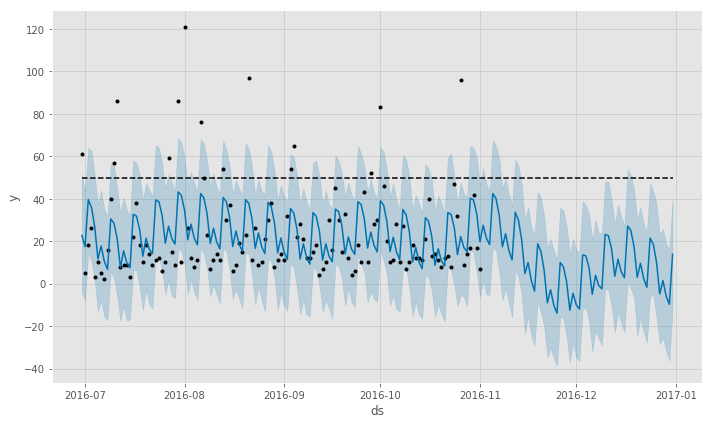

In [158]:
m2.plot(preds);

KeyError: 'train'

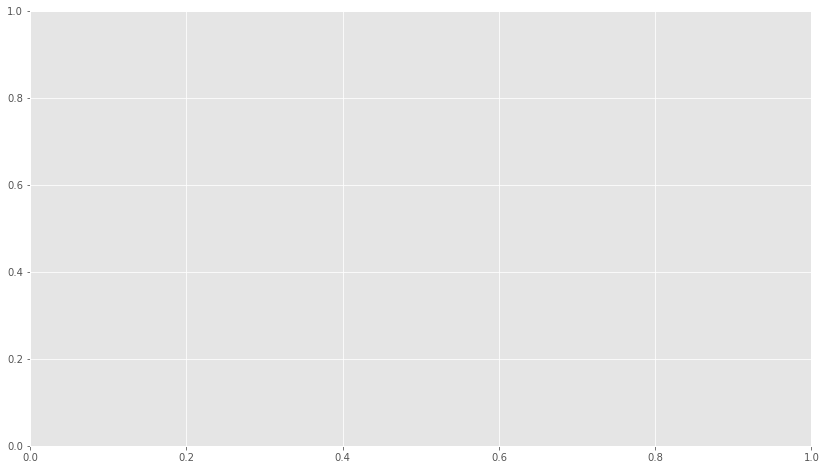

In [159]:
wiki.newphet.prophet_plot(preds)

In [105]:
wiki.val.smape_df(df6,'y','yhat')

365    0.423086
366    0.117065
367    0.284702
368    0.306626
369    0.149421
dtype: float64
365     88.357577
366    114.577295
367     73.552154
368     30.412542
369    159.844876
dtype: float64


-159.13762772478

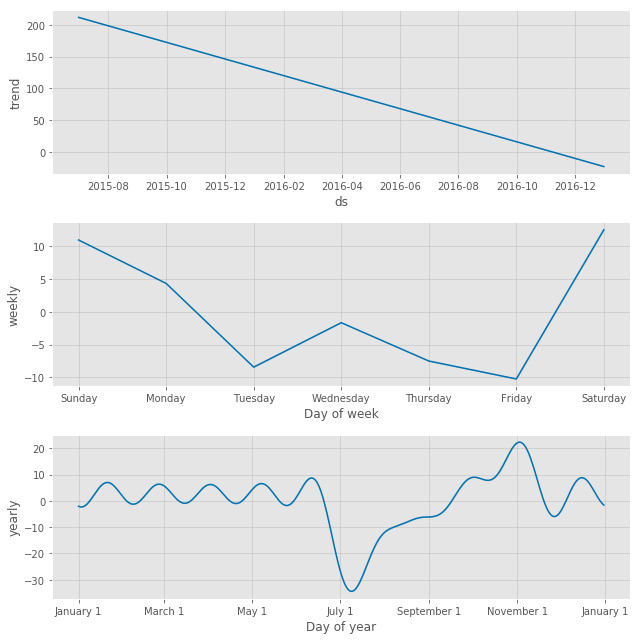

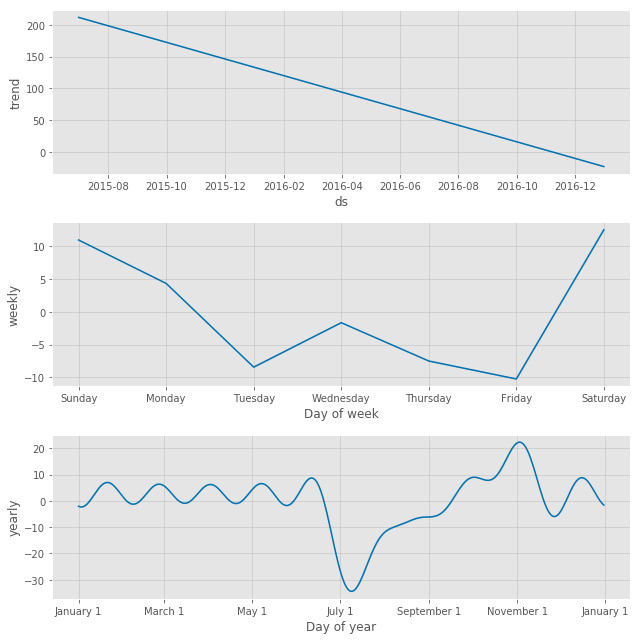

In [28]:
m6.plot_components(df6)

In [103]:
pd.read_feather(PROPHET_PATH+'page_index.f')

,index,Page
0,0,2NE1_zh.wikipedia.org_all-access_spider
1,1,2PM_zh.wikipedia.org_all-access_spider
2,2,3C_zh.wikipedia.org_all-access_spider
3,3,4minute_zh.wikipedia.org_all-access_spider
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
5,5,5566_zh.wikipedia.org_all-access_spider
6,6,91Days_zh.wikipedia.org_all-access_spider
7,7,A'N'D_zh.wikipedia.org_all-access_spider
8,8,AKB48_zh.wikipedia.org_all-access_spider
9,9,ASCII_zh.wikipedia.org_all-access_spider
